# 1 and 2: Preparation and Data Set

In [291]:
import numpy as np 

#Possible combinations of inputs
inputs = np.array([[0,0],[0,1],[1,0],[1,1]])

#Target results for each logical gate. The array index matches the index of the corresponding input in the "inputs" array.
target_and = np.array([0,0,0,1])
target_or = np.array([0,1,1,1])
target_nand = np.array([1,1,1,0])
target_nor = np.array([1,0,0,0])
target_xor = np.array([0,1,1,0])

#Sigmoid function
def sigmoid(x): 
    return (1 / (1 + np.exp(-x)))

#Derivative of Sigmoid
def sigmoidprime(x):
    return (sigmoid(x) * (1 - sigmoid(x)))

# 3: Perceptron class

In [292]:
class Perceptron:
    
    def __init__(self, input_units):
        #Amount of input units
        self._input_units = input_units
        #Initializes the weights and the bias randomly.
        self._weights = np.random.randn(input_units)
        self._bias = np.random.randn()
        #Learning rate alpha
        self._alpha = 1
        #Variable to save the drive. Will be overwritten after every "forward_step".
        self._drive = 0
        #Array to save the activations of the previous layer (In case of the first hidden layer the inputs of the MLP). 
        #Will be overwritten after every "forward_step".
        self._activations_previous_layer = np.empty(input_units)
        
    def forward_step(self, inputs):
        #Inputs (activations of the previous layer) are saved for the backpropagation.
        self._activations_previous_layer = inputs
        
        #Conducts a forward step.
        self._drive = np.dot(inputs, self._weights) + self._bias 
        
        #Applies the activation function sigmoid.
        activation = sigmoid(self._drive)
        return activation             
    
    def update(self, delta):
        #Updates the weights of the perceptron.
        self._weights -= self._alpha * delta * self._activations_previous_layer
        
        #Updates the bias of the perceptron.
        self._bias -= self._alpha * delta * 1
        
    #getter methods
    def _get_drive(self):
        return self._drive
    
    def _get_weights(self):
        return self._weights

# 4: Multi-Layer Perceptron class

In [293]:
class MLP:
    
    def __init__(self, size_hidden_layer):
        #Size of hidden layer
        self._size_hidden_layer = size_hidden_layer
        
        #Initializes the hidden layer (A list consisting of the neurons/ perceptrons of the hidden layer).
        self._hidden_layer = [None for i in range(size_hidden_layer)]
        amount_of_inputs = 2                                                #Two binary inputs of the logical gate
        for i in range(self._size_hidden_layer):
            self._hidden_layer[i] = Perceptron(amount_of_inputs)
        
        #Initializes the output layer. In this case just one neuron/ perceptron.
        self._output_layer = Perceptron(size_hidden_layer)
        
    def forward_step(self, inputs):
        #Computes the activations of the hidden layer by iterating over the Perceptrons in the array "_hidden_layer". 
        activations_hidden_layer = np.empty(self._size_hidden_layer)
        for i in range(self._size_hidden_layer):
            activations_hidden_layer[i] = self._hidden_layer[i].forward_step(inputs)
            
        #Computes the activation of the output layer.
        prediction = self._output_layer.forward_step(activations_hidden_layer)
        return prediction
        
    def backprop_step(self, loss):
        #Calculates the delta of the output layer.
        delta_output_layer = loss * sigmoidprime(self._output_layer._get_drive())
        
        #Calculates the deltas of the hidden layer. In the first step it is only the delta of the output layer multiplied
        #by the weights between hidden layer and output layer. (-> This needs to be done before the weights are updated.)
        weighted_delta_output_layer = delta_output_layer * self._output_layer._get_weights()
        #Second step: Multiplying with the derivative of the drive of each perceptron.
        deltas_hidden_layer = np.empty(self._size_hidden_layer)
        for i in range(self._size_hidden_layer):             
            deltas_hidden_layer[i] = weighted_delta_output_layer[i] * sigmoidprime(self._hidden_layer[i]._get_drive())
        
        #Updates the output layer perceptron.
        self._output_layer.update(delta_output_layer) 
          
        #Updates the hidden layer perceptrons.
        for i in range(self._size_hidden_layer):
            self._hidden_layer[i].update(deltas_hidden_layer[i])
        

# 5: Training

In [304]:
#Defines the size of the hidden layer.
size_hidden_layer = 4
#Defines the logical gate which should be learned. This is done by choosing the corresponding target result array.
target = target_xor    #target_and, target_or, target_nand, target_nor, target_xor

#Initializes the corresponding Multi-Layer Perceptron.
logical_gate = MLP(size_hidden_layer)

#Defines the amount of training epochs.
amount_of_training_epochs = 1000
#Initializes the arrays to save the steps and the average accuracy and loss of each epoch.
steps = np.empty(amount_of_training_epochs)
average_accuracy_each_epoch = np.empty(amount_of_training_epochs)
average_loss_each_epoch = np.empty(amount_of_training_epochs)

#Conducts the training epochs.
for epoch in range(amount_of_training_epochs):
    #Saves the current epoch step.
    steps[epoch] = epoch
    #Defines the counting variables which are necessary to compute the average accuracy and loss. 
    correct_predictions_current_epoch = 0
    loss_current_epoch = 0
    
    #Loops over each point in the input-dataset once.
    for i in range(len(inputs)):
        #Performs a forward step which returns the prediction.
        prediction = logical_gate.forward_step(inputs[i])
    
        #Increments the "correct_predictions_current_epoch" count if the current predictions is correct.
        if (prediction <= 0.5 and target[i] == 0) or (prediction > 0.5 and target[i] == 1):
            correct_predictions_current_epoch += 1
    
        #Calculates the loss after the current forward step. 
        loss_current_epoch += np.square(target[i] - prediction)    #SQUARED ERROR!
        #Calculates the loss between target and prediction which is given to the "backprop_step" function afterwards.
        loss = -(target[i] - prediction)                          #NORMAL ERROR, because backpropagation doesnt work otherwise!
    
        #Performs the corresponding backpropagation step.
        logical_gate.backprop_step(loss)
    
    #Updates the average accuracy and loss arrays.
    average_accuracy_each_epoch[epoch] = correct_predictions_current_epoch / len(inputs)
    average_loss_each_epoch[epoch] = loss_current_epoch / len(inputs) 

# 6: Visualization

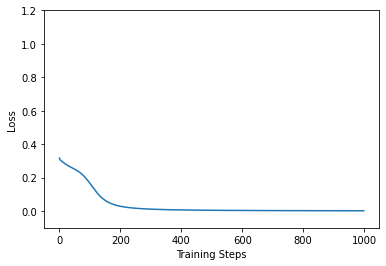

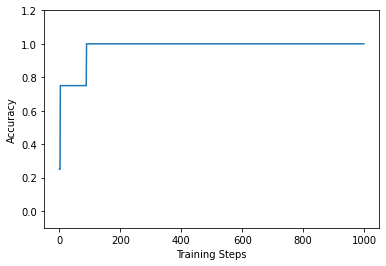

In [305]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(steps, average_loss_each_epoch)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.ylim([-0.1, 1.2])
plt.show()

plt.figure()
plt.plot(steps, average_accuracy_each_epoch)
plt.xlabel("Training Steps")
plt.ylabel("Accuracy")
plt.ylim([-0.1, 1.2])
plt.show()